In [1]:
import segmentation_models as sm

import math
import pathlib
import typing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
from functools import cached_property

import os

import pandas as pd
import time
import pickle

from matplotlib.ticker import MaxNLocator

from utils_and_constants import labels, TARGET_SIZE
from sklearn.model_selection import train_test_split
from focal_loss import SparseCategoricalFocalLoss

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["NO_ALBUMENTATIONS_UPDATES"] = "1"

np.random.seed(314)
tf.random.set_seed(314)

print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())

2025-02-28 06:42:46.693154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-28 06:42:46.693185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


/home/hedredo/github/oc_p8/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Number of CPU cores available:  16


On modifie uniquement la classe inhéritée de tensorflow, à savoir tf.keras.utils.Sequence, qui n'est autre que l'alias original de tf.keras.utils.PyDataset.<br>
J'intègre également la fonction de prétraitement personnalisée dans la classe, pour que le prétraitement soit effectué en temps réel lors de l'entraînement du modèle.

In [43]:
class ImageSegmentationDataset(tf.keras.utils.Sequence):
    """
    Dataset generator for image segmentation tasks.

    This class extends the PyDataset utility from TensorFlow/Keras and provides data
    loading, optional augmentation, and preprocessing for both images and corresponding segmentation masks.

    Attributes:
        image_paths (List[pathlib.Path]): List of image file paths.
        mask_paths (List[pathlib.Path]): List of corresponding mask file paths.
        table_id2category (dict): Mapping from label id to category id.
        table_category2name (dict): Mapping from category id to category name.
        batch_size (int): Number of samples per batch.
        target_size (Tuple[int, int]): Target dimensions (height, width) for resizing images and masks.
        augmentations (bool): Flag to determine if augmentation pipeline should be applied.
        normalize (bool): Flag to normalize image values to [0, 1].
        shuffle (bool): Whether to shuffle the dataset at the end of every epoch.
        label_onehot (bool): If True, masks will be converted to one-hot encoded format.
        sample_weights (List[float] | None): Optional list of weights per mask label.
    """

    def __init__(
        self,
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: bool = False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool | str = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        sample_weights: typing.List[float] = None,
        **kwargs,
    ):
        """
        Initialize the ImageSegmentationDataset.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples containing image and mask paths.
            labels (typing.NamedTuple): Named tuple with information for mapping labels (e.g., id, categoryId, category).
            batch_size (int): Number of samples per batch.
            target_size (Tuple[int, int]): Target size for resizing images and masks (height, width).
            augmentations (bool, optional): Apply augmentations if True. Defaults to False.
            preview (int, optional): If provided, limits the dataset to the first 'preview' samples. Defaults to None.
            normalize (bool, optional): Normalize images by scaling to [0, 1] if True. Defaults to True.
            shuffle (bool, optional): Shuffle dataset on each epoch end. Defaults to True.
            label_onehot (bool, optional): Convert masks to one-hot encoding if True. Defaults to False.
            sample_weights (List[float], optional): List of weights for mask labels. Defaults to None.
            **kwargs: Additional keyword arguments for parent class.
        """
        super().__init__()

        # Load the image and mask paths (apply preview slicing if needed)
        self.image_paths, self.mask_paths = self.load_img_and_mask_paths(paths, preview)

        # Create mapping tables from labels for category conversions
        self.table_id2category = {label.id: label.categoryId for label in labels}
        self.table_category2name = {
            label.categoryId: label.category for label in labels
        }

        # Initialize dataset parameters
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.sample_weights = sample_weights

        # Initialize augmentation pipeline if enabled
        if self.augmentations:
            self.compose = A.Compose(
                [
                    # Geometric transformation: Horizontal flip with probability 0.5.
                    A.HorizontalFlip(p=0.5),
                    # Color adjustments with one of the provided transformations.
                    A.OneOf(
                        [
                            A.RandomBrightnessContrast(
                                brightness_limit=0.2, contrast_limit=0.2, p=1.0
                            ),
                            A.HueSaturationValue(
                                hue_shift_limit=10,
                                sat_shift_limit=15,
                                val_shift_limit=10,
                                p=1.0,
                            ),
                        ],
                        p=0.5,
                    ),
                    # Apply blur or distortion effects.
                    A.OneOf(
                        [
                            A.GaussianBlur(blur_limit=3, p=1.0),
                            A.MotionBlur(blur_limit=5, p=1.0),
                            A.OpticalDistortion(distort_limit=0.05, p=1.0),
                        ],
                        p=0.25,
                    ),
                ],
                # If sample_weights are provided, augment them together with the masks.
                additional_targets={"sample_weights": "mask"}
                if self.sample_weights is not None
                else {},
            )

        # Shuffle dataset initially if shuffle is enabled.
        if self.shuffle:
            self.on_epoch_end()

    @cached_property
    def num_classes(self):
        """
        Return the number of unique classes in the dataset.
        The result is cached after the first calculation.
        """
        return len(set(self.table_id2category.values()))

    @cached_property
    def num_samples(self):
        """
        Return the total number of samples in the dataset.
        The result is cached after the first calculation.
        """
        return len(self.image_paths)

    @staticmethod
    def load_img_and_mask_paths(
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]], preview: int
    ) -> typing.Tuple[typing.List[pathlib.Path], typing.List[pathlib.Path]]:
        """
        Unpack tuples of image and mask paths and apply preview slicing if specified.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples where each tuple contains
                (image_path, mask_path).
            preview (int): If provided, only load the first 'preview' entries from the lists.

        Returns:
            Tuple[List[pathlib.Path], List[pathlib.Path]]: Two lists containing image and mask paths.

        Raises:
            ValueError: If the number of images and masks do not match.
        """
        # Unpack the tuples into separate lists
        image_paths, mask_paths = zip(*paths)
        if len(image_paths) != len(mask_paths):
            raise ValueError("Number of images and masks must be equal.")
        # Slice lists if preview limit is set
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]
        return list(image_paths), list(mask_paths)

    def __len__(self) -> int:
        """
        Return the number of batches per epoch.

        Returns:
            int: Total number of batches.
        """
        length = math.ceil(self.num_samples / self.batch_size)
        return length

    def __getitem__(self, index: int):
        """
        Fetch a batch of images and masks at the given index.

        Args:
            index (int): Batch index.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Depending on whether sample_weights is provided; returns images, masks and optionally weights.

        Raises:
            IndexError: If the calculated start index is out of range.
        """
        # Determine start and end indices for this batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Pair image and mask paths for the current batch
        batch_paths = list(
            zip(self.image_paths[start_idx:end_idx], self.mask_paths[start_idx:end_idx])
        )

        # Process each pair: load and apply augmentations (if enabled)
        results = [self.load_and_augment(pair) for pair in batch_paths]

        # Unpack and return batch data based on sample weight availability
        if self.sample_weights is not None:
            images, masks, weights = zip(*results)
            return np.asarray(images), np.asarray(masks), np.asarray(weights)
        else:
            images, masks = zip(*results)
            return np.asarray(images), np.asarray(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            # Combine paths into list of tuples, shuffle and then unpack.
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        # If shuffle is disabled, do nothing.

    def _normalize_img(self, img_array):
        """
        Normalize an image array to a range of [0, 1].

        Args:
            img_array (np.ndarray): Image data as a numpy array.

        Returns:
            np.ndarray: Normalized image array.
        """
        match self.normalize:
            case True:
                return img_array / 255.0
            case False:
                return img_array
            case _:
                try:
                    preprocess_input = sm.get_preprocessing(self.normalize)
                    return preprocess_input(img_array)
                except AttributeError as e:
                    print(
                        f"Invalid normalization option: {self.normalize}. Should be True, False or a valid backbone name."
                    )
                    raise e

    def load_img_to_array(self, img_path: pathlib.Path):
        """
        Load an image from disk, resize, and convert it to a numpy array.

        Args:
            img_path (pathlib.Path): File path to the image.

        Returns:
            np.ndarray: Image data as a numpy array (optionally normalized).
        """
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    def load_mask_to_array(self, mask_path: pathlib.Path):
        """
        Load a mask from disk, resize, map mask ids to category ids, and optionally one-hot encode.

        Args:
            mask_path (pathlib.Path): File path to the mask image.

        Returns:
            np.ndarray: Processed mask array.
        """
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids using the table; squeeze is used to drop extra dimensions.
        mask_array = np.vectorize(self.table_id2category.get)(mask_array).squeeze()
        if self.label_onehot:
            mask_array = tf.keras.utils.to_categorical(
                mask_array, num_classes=self.num_classes
            )
        return mask_array

    def load_and_augment(self, paths):
        """
        Load image and mask, and apply augmentations if enabled.

        Args:
            paths (Tuple[pathlib.Path, pathlib.Path]): Tuple containing image and mask paths.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Processed image, mask and optionally sample weights.
        """
        img_path, mask_path = paths
        img = self.load_img_to_array(img_path)
        mask = self.load_mask_to_array(mask_path)

        if self.sample_weights is not None:
            weights = np.take(self.sample_weights, mask)
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask, sample_weights=mask)
                return (
                    augmented["image"],
                    augmented["mask"],
                    augmented["sample_weights"],
                )
            else:
                return img, mask, weights
        else:
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask)
                return augmented["image"], augmented["mask"]
            else:
                return img, mask

    def get_image_and_mask(self, index: int):
        """
        Retrieve a single image/mask pair for visualization purposes.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[np.ndarray, np.ndarray, Tuple[pathlib.Path, pathlib.Path]]:
                Processed image, mask and original file paths.
        """
        paths = (self.image_paths[index], self.mask_paths[index])
        if self.sample_weights is None:
            img, mask = self.load_and_augment(paths)
        else:
            img, mask, _ = self.load_and_augment(paths)
        return img, mask, paths

    def get_prediction(self, model, index: int):
        """
        Generate a prediction for a given image sample using the provided model.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample to predict.

        Returns:
            np.ndarray: Predicted mask with labels.
        """
        img, _, _ = self.get_image_and_mask(index)
        mask_pred = model.predict(np.expand_dims(img, axis=0))
        mask_pred = np.argmax(mask_pred.squeeze(), axis=-1)
        return mask_pred

    def show_transformation(self, index: int, figsize=(10, 6)):
        """
        Display the original and transformed images and masks for a given sample.

        Args:
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (10, 6).
        """
        # Retrieve sample data and file paths
        img, mask, paths = self.get_image_and_mask(index)
        img_path, mask_path = paths

        # Prepare subplots for original and transformed images/masks
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax[0, 0].imshow(plt.imread(img_path))
        ax[0, 0].set_title("Original Image")
        ax[0, 1].imshow(img)
        ax[0, 1].set_title("Transformed Image")
        ax[1, 0].imshow(plt.imread(mask_path))
        ax[1, 0].set_title("Original Mask")
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed Mask")
        plt.show()

    def show_prediction(self, model, index: int, figsize=(15, 6)):
        """
        Display the original image, ground truth, and model prediction for a sample.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (15, 6).
        """
        # Retrieve processed sample and generate prediction
        img, mask, _ = self.get_image_and_mask(index)
        mask_pred = self.get_prediction(model, index)

        # Initialize figure with a constrained layout
        fig = plt.figure(layout="constrained", figsize=figsize)
        fig.suptitle(f"{model.name} Predictions", fontsize=16)

        # Create top and bottom subfigures for comparing ground truth and predictions
        subfigs = fig.subfigures(2, 1, wspace=0.07)
        axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
        axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)

        # Plot original image, ground truth mask (grayscale and RGB)
        for i, ax in enumerate(axsTop):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask, cmap="Greys")
                ax.set_title("Ground Truth Mask (Grayscale)")
            else:
                ax.imshow(mask)
                ax.set_title("Ground Truth Mask (RGB)")
            ax.axis("off")

        # Plot original image, predicted mask (grayscale and RGB)
        for i, ax in enumerate(axsBottom):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask_pred, cmap="Greys")
                ax.set_title("Predicted Mask (Grayscale)")
            else:
                ax.imshow(mask_pred)
                ax.set_title("Predicted Mask (RGB)")
            ax.axis("off")
        plt.show()

**Passons à la préparation des variables pour charger les répertoires d'entraînement (split en train et val) et de test:**

In [3]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))


Train files:  8925
Test files:  1500


In [4]:
# Get the full train image and masks paths to analyse the classes
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
full_train_paths = list(zip(image_paths, mask_paths))

# Split the full train paths into train and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

# Finally, get the test image and mask paths
image_paths = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths, mask_paths))

# Print len of train, val and test paths
print("Train paths: ", len(train_paths))
print("Val paths: ", len(val_paths))
print("Test paths: ", len(test_paths))

Train paths:  2380
Val paths:  595
Test paths:  500


In [5]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, smooth=1e-5, name="dice_metric", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert the sparse y_true to one-hot encoding
        y_true_onehot = tf.one_hot(
            y_true, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Convert the y_pred probabilities with argmax
        y_pred_indices = tf.argmax(y_pred, axis=-1)  # (batch, h, w)
        # Convert the y_pred indices to one-hot encoding
        y_pred_onehot = tf.one_hot(
            y_pred_indices, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Flatten the one-hot tensors on all axes except batch
        y_true_flat = tf.reshape(
            y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)
        y_pred_flat = tf.reshape(
            y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)

        # Compute intersection and union for each class
        intersection = tf.reduce_sum(
            y_true_flat * y_pred_flat, axis=1
        )  # (batch, num_classes)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(
            y_pred_flat, axis=1
        )  # (batch, num_classes)

        # Compute DICE score for each class with the smoothening factor
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute the DICE mean score for each image
        dice_per_image = tf.reduce_mean(dice, axis=-1)  # (batch,)

        # Update the total dice and count with the mean dice score per image
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    def result(self):
        # Compute the mean dice score over all images
        return self.total_dice / self.count

    def reset_states(self):
        # Reset the total dice and count at the end of each epoch
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

https://segmentation-models.readthedocs.io/en/latest/api.html#metrics

In [8]:
sm.metrics.IOUScore(
    name="IoU_score",
    class_indexes=[*range(8)],
    class_weights=None,
    per_image=False,
    threshold=0.5,
)

In [ ]:
sm.metrics.IOUScore(
    name="IoU_score",
    class_indexes=1,
    class_weights=None,
    per_image=False,
    threshold=0.5,
)

In [105]:
sm.metrics.FScore?

Init signature:
sm.metrics.FScore(
    beta=1,
    class_weights=None,
    class_indexes=None,
    threshold=None,
    per_image=False,
    smooth=1e-05,
    name=None,
)
Docstring:     
The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
where an F-score reaches its best value at 1 and worst score at 0.
The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
The formula for the F score is:

.. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
    {\beta^2 \cdot precision + recall}

The formula in terms of *Type I* and *Type II* errors:

.. math:: L(tp, fp, fn) = \frac{(1 + \beta^2) \cdot tp} {(1 + \beta^2) \cdot fp + \beta^2 \cdot fn + fp}

where:
     - tp - true positives;
     - fp - false positives;
     - fn - false negatives;

Args:
    beta: Integer of float f-score coefficient to balance precision and recall.
    class_weights: 1. or ``np.array`` of class weights (``len(

In [ ]:
# iou = sm.metrics.IOUScore(threshold=0.5)
# dicecoef = sm.metrics.FScore(beta=1.0, threshold=0.5)
# sm.metrics.dice_score = DiceMetric(num_classes=20)

In [ ]:
mean_metrics = [
    sm.metrics.IOUScore(
        name="MeanIoU",
        class_indexes=[*range(8)],
        class_weights=None,
        per_image=False,
        threshold=0.5,
    ),
    tf.keras.metrics.CategoricalAccuracy(name="Pixel_Accuracy"),
]

In [ ]:
per_class_metrics = [
    sm.metrics.IOUScore(
        name=f"IoU_class_{i}",
        class_indexes=i,
        class_weights=None,
        per_image=False,
        threshold=0.5,
    )
    for i in range(8)
]

In [101]:
class ModelMetric:
    def __init__(
        self,
        history: dict,
        results: dict,
        extra_metrics: dict,
        monitor: str,
        best_monitor: str,
    ):
        """ """
        self.history_metrics = {
            (f"train_{k}" if not k.startswith("val") else k): v
            for k, v in history.history.items()
        }
        self.history_params = history.params
        self.epochs_list = history.epoch
        self.results = results
        self.extra_metrics = extra_metrics
        self.monitor = monitor
        self.best_monitor = best_monitor

        def get_model_name(history):
            if hasattr(history, "model"):
                return history.model.custom_name
            else:
                return history._model.name

        self.model_name = get_model_name(history)

    @classmethod
    def from_pickle(
        cls,
        pickle_path: str,
    ):
        with open(pickle_path, "rb") as f:
            return pickle.load(f)

    @property
    def best_epoch(self):
        # Take the epoch with the best validation loss
        match self.best_monitor.lower().strip():
            case "max":
                return self.history_metrics[self.monitor].index(
                    max(self.history_metrics[self.monitor])
                )
            case "min":
                return self.history_metrics[self.monitor].index(
                    min(self.history_metrics[self.monitor])
                )
            case _:
                raise ValueError(
                    f"Unknown monitor: {self.monitor}. Must be 'max' or 'min'."
                )

    @cached_property
    def metrics_df(self):
        # Create a DataFrame with the best epoch metrics
        train_val_metrics = (
            pd.DataFrame(self.history_metrics)
            .iloc[self.best_epoch, :]
            .to_frame()
            .T.reset_index(drop=True)
        )
        test_metrics = pd.DataFrame(
            data=[self.results.values()],
            columns=[f"test_{k}" for k in self.results.keys()],
        )
        metrics_df = pd.concat([train_val_metrics, test_metrics], axis=1)
        metrics_df = metrics_df.assign(
            best_epoch=self.best_epoch,
            n_epochs=self.history_params.get("epochs"),
            n_steps=self.history_params.get("steps"),
            model_name=self.model_name,
        )
        metrics_df.insert(
            0, "experiment_folder", self.extra_metrics.get("experiment_folder")
        )
        for key, value in self.extra_metrics.items():
            if key != "experiment_folder":
                metrics_df[key] = value
        return metrics_df

    def save_metrics(
        self, metrics_path: str = "../metrics.csv", artifacts_path: str = "../artifacts"
    ):
        # Save metrics as a CSV file if it does not exist
        if not os.path.exists(metrics_path):
            self.metrics_df.to_csv(metrics_path, mode="a", header=True, index=False)
            print(f"Metrics file created at {metrics_path}")
        # Else, append the metrics to the existing file
        else:
            self.metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
            print(f"Metrics file updated at {metrics_path}")

        # Save model_metric as a pickle file
        with open(
            f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/model_metric.pkl",
            "wb",
        ) as f:
            pickle.dump(self, f)
            print(f"Pickle file created at {artifacts_path}")

    def plot_loss(self, figsize=(12, 6), artifacts_path: str = "../artifacts"):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_loss.png"
        # Plot the training and validation loss
        fig = plt.figure(figsize=figsize)
        plt.plot(
            self.epochs_list,
            self.history_metrics["train_loss"],
            label="train_loss",
            color="blue",
        )
        plt.plot(
            self.epochs_list,
            self.history_metrics["val_loss"],
            label="val_loss",
            color="red",
        )
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.model_name} Training and Validation Loss Curve per epoch")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
        plt.legend()
        plt.show()
        fig.savefig(fig_path)

    def plot_train_metrics(
        self, figsize=(20, 10), artifacts_path: str = "../artifacts"
    ):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_train_metrics.png"
        history_metrics_df = pd.DataFrame(self.history_metrics)
        fig, ax = plt.subplots(
            2, 2, figsize=figsize, sharex=True, sharey=True, tight_layout=True
        )
        fig.suptitle(f"{self.model_name} Training Metrics Curve per epoch", fontsize=16)
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}")
                    and "loss" not in col
                    and "class" not in col
                ]
            ).plot(ax=ax[0, i], title=f"{split} mean metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}_IoU") and "loss" not in col
                ]
            ).plot(ax=ax[1, i], title=f"{split} per class metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        plt.show()
        fig.savefig(fig_path)

    def plot_test_metrics(self, figsize=(20, 10), artifacts_path: str = "../artifacts"):
        # fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_test_metrics.png"
        pass

In [15]:
class ComparativeMetric:
    def __init__(self, path="../metrics.csv"):
        self.metrics_df = pd.read_csv(path).drop_duplicates(keep="last")

In [16]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, from_logits=False, smooth=1e-6, name="dice_loss"):
        """
        Dice Loss pour segmentation multi-classe.

        Args:
            num_classes (int): Nombre de classes dans la segmentation.
            from_logits (bool): Si True, applique `softmax` avant le calcul.
            smooth (float): Facteur de lissage pour éviter la division par zéro.
            name (str): Nom de la loss.
        """
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth

    def call(self, y_true, y_pred):
        """
        Calcul de la perte Dice.

        Args:
            y_true (tensor): Vraies étiquettes (batch, H, W) ou (batch, H, W, C).
            y_pred (tensor): Prédictions (batch, H, W, C).

        Returns:
            Tensor: Dice Loss
        """
        # Convertir y_true en one-hot si nécessaire
        if tf.shape(y_true).shape == 3:  # (batch, H, W) → (batch, H, W, C)
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)

        if self.from_logits:
            y_pred = tf.nn.softmax(
                y_pred, axis=-1
            )  # Conversion des logits en probabilités

        # Calcul de l'intersection et de l'union pour chaque classe
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Moyenne sur toutes les classes
        return 1 - tf.reduce_mean(dice_score, axis=-1)


In [17]:
# Create a class from tf.keras.losses.Loss combining dice loss and sparse categorical crossentropy
class DiceCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        num_classes,
        from_logits=False,
        smooth=1e-6,
        alpha=0.7,
        name="dice_crossentropy_loss",
    ):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # Compute the dice loss
        dice_loss = DiceLoss(
            num_classes=self.num_classes,
            from_logits=self.from_logits,
            smooth=self.smooth,
        )(y_true, y_pred)
        # Compute the sparse categorical crossentropy loss
        scce_loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=self.from_logits
        )(y_true, y_pred)
        # Return the sum of both losses weighted by alpha
        return self.alpha * dice_loss + (1 - self.alpha) * scce_loss

In [18]:
# Create a class from tf.keras.losses.Loss combining dice loss and focal loss
class DiceFocalLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        num_classes,
        from_logits=False,
        smooth=1e-6,
        alpha=0.7,
        gamma=2.0,
        name="dice_focal_loss",
    ):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Compute the dice loss
        dice_loss = DiceLoss(
            num_classes=self.num_classes,
            from_logits=self.from_logits,
            smooth=self.smooth,
        )(y_true, y_pred)
        # Compute the focal loss
        focal_loss = SparseCategoricalFocalLoss(
            gamma=self.gamma,
            from_logits=self.from_logits,
            name="sparse_categorical_focal_loss",
        )(y_true, y_pred)
        # Return the sum of both losses
        return self.alpha * dice_loss + (1 - self.alpha) * focal_loss

# 6. Advanced Architectures

## 6.1. UNET DECODER + ENCODER RESNET (+imagepreprocessing)

In [ ]:
BACKBONE = "resnet50"
SEGMENTATION_MODEL = "Unet"

train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
    normalize=BACKBONE,
    preview=128,
    label_onehot=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
    normalize=BACKBONE,
    preview=32,
    label_onehot=True,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
    normalize=BACKBONE,
    preview=32,
    label_onehot=True,
)

In [ ]:
model = sm.Unet(
    BACKBONE,
    classes=train_datagen.num_classes,
    activation="softmax",
    encoder_weights="imagenet",
    input_shape=(256, 512, 3),
    encoder_freeze=True,
)

# Folder to create to store artifacts
new_folder = 610

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_loss",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Set Mean IoU as the metric to monitor to stop the training
    patience=4,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Create a ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Factor to reduce the learning rate
    patience=2,  # Epochs to wait before reducing the learning rate
    mode="max",
    min_lr=1e-6,  # Minimum learning rate
)

# Define the loss function
loss_fn = sm.losses.DiceLoss()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Pretrain the model decoder for the 2 first epochs
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
)

# Pretrain the model decoder for the 2 first epochs
history_pretrain = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=2,
    workers=NUM_WORKERS,
)

for layer in model.layers:
    layer.trainable = True  # Ou False selon le besoin

# Recompiler
model.compile(
    optimizer=optimizer, loss=loss_fn, metrics=mean_metrics + per_class_metrics
)

# Train the full model for 50 epochs
history_train = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=4,
    workers=NUM_WORKERS,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
)


Epoch 1/2
8/8 [==============================] - 97s 12s/step - loss: 0.8764 - IoU_score: 0.0148 - Pixel_Accuracy: 0.1883 - IoU_score_0: 0.0081 - IoU_score_1: 0.0127 - IoU_score_2: 0.0263 - IoU_score_3: 0.0106 - IoU_score_4: 0.0529 - IoU_score_5: 1.6048e-10 - IoU_score_6: 9.4865e-04 - IoU_score_7: 0.0066 - val_loss: 0.9017 - val_IoU_score: 1.4640e-10 - val_Pixel_Accuracy: 0.1407 - val_IoU_score_0: 5.2616e-11 - val_IoU_score_1: 1.1798e-11 - val_IoU_score_2: 1.8925e-11 - val_IoU_score_3: 2.5795e-10 - val_IoU_score_4: 3.8380e-11 - val_IoU_score_5: 1.8955e-10 - val_IoU_score_6: 5.2496e-10 - val_IoU_score_7: 7.7046e-11
Epoch 2/2
8/8 [==============================] - 93s 12s/step - loss: 0.8304 - IoU_score: 0.0553 - Pixel_Accuracy: 0.3681 - IoU_score_0: 0.0557 - IoU_score_1: 0.1101 - IoU_score_2: 0.0920 - IoU_score_3: 0.0063 - IoU_score_4: 0.1550 - IoU_score_5: 1.6435e-10 - IoU_score_6: 6.5807e-04 - IoU_score_7: 0.0226 - val_loss: 0.8981 - val_IoU_score: 1.4640e-10 - val_Pixel_Accuracy: 0.2

In [ ]:
def combine_history(
    history_pretrain: tf.keras.callbacks.History,
    history_train: tf.keras.callbacks.History,
    model_name: str,
):
    """
    Combine the pretrain and train history objects into a single history object.

    Args:
        history_pretrain (tf.keras.callbacks.History): History object from the pretrain phase.
        history_train (tf.keras.callbacks.History): History object from the training phase.

    Returns:
        tf.keras.callbacks.History: Combined history object.
    """
    # Create a keras history object from the training history and pretrain history
    history = tf.keras.callbacks.History()
    history.history = {
        k: history_pretrain.history[k] + history_train.history[k]
        for k in history_pretrain.history.keys()
    }
    history.params = history_train.params
    history.epoch = [*range(len(history_train.epoch) + len(history_pretrain.epoch))]
    history.model = history_train.model
    history.model.custom_name = model_name
    return history


# Create a keras history object from the training history and pretrain history
history = combine_history(history_pretrain, history_train, f"{SEGMENTATION_MODEL}_{BACKBONE}")


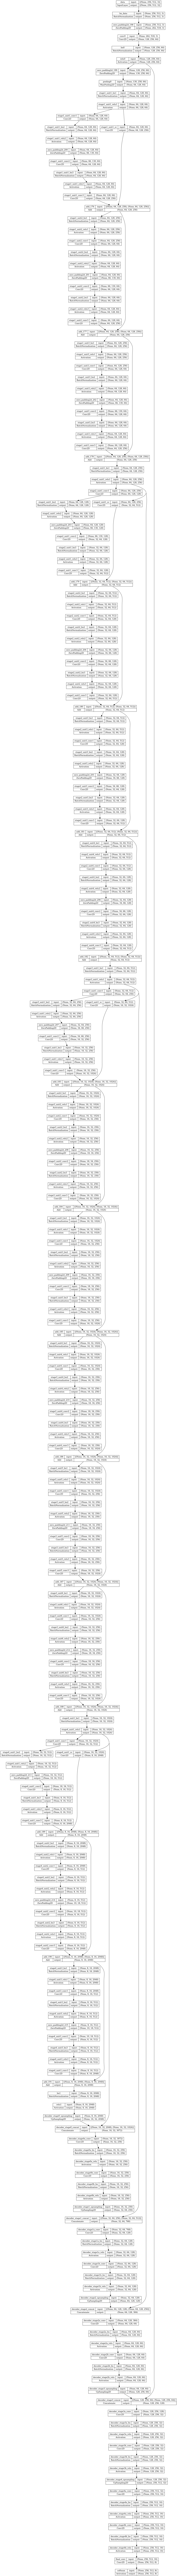

In [ ]:
tf.keras.utils.plot_model(
    model,
    f"{SEGMENTATION_MODEL}_{BACKBONE}_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [56]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights(f"../artifacts/{new_folder}/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

1/1 [==============================] - 1s 512ms/step
Inference time on a unique prediction: 0.62 seconds


In [104]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/61/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.lr.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

KeyError: 'val_MeanIoU'

## 6.2. FPN DECODER + EFFICIENT NET ENCODER

In [ ]:
BACKBONE = "efficientnetb0"

train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
    normalize=BACKBONE,
    preview=128,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
    normalize=BACKBONE,
    preview=32,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
    normalize=BACKBONE,
    preview=32,
)

In [ ]:
model = sm.FPN(
    BACKBONE,
    classes=train_datagen.num_classes,
    activation="softmax",
    encoder_weights="imagenet",
    input_shape=(256, 512, 3),
    encoder_freeze=True,
)

# Folder to create to store artifacts
new_folder = 611

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=4,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Create a ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_MeanIoU",
    factor=0.5,  # Factor to reduce the learning rate
    patience=2,  # Epochs to wait before reducing the learning rate
    mode="max",
    min_lr=1e-6,  # Minimum learning rate
)

# Define the loss function
loss_fn = DiceFocalLoss(
    num_classes=train_datagen.num_classes,
    from_logits=False,
    smooth=1e-6,
    alpha=0.8,
    name="dice_focal_loss",
)


# Optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Pretrain the model decoder for the 2 first epochs
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
)

# Pretrain the model decoder for the 2 first epochs
history_pretrain = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    epochs=2,
    workers=NUM_WORKERS,
)

sm.utils.set_trainable(model)

# Train the full model for 50 epochs
history_train = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    epochs=4,
    workers=NUM_WORKERS,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
)

In [ ]:
tf.keras.utils.plot_model(
    model,
    "fpn_efficientnet_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/62/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/62/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

## 6.3. SOTA ?

# 7. Conclusion